In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imageio
import pandas as pd
import torch 
import numpy as np
import albumentations as A

import matplotlib.pyplot as plt
import time

# Reload the model 
reload_model = tf.keras.models.load_model('/media/beta/mitko-beps/mandy/notebooks/Pretrain_FineTune/Finetune_logs/tf_finetuning_on_single_labels')
sample_submission = pd.read_csv("/media/beta/mitko-beps/data/sample_submission.csv")

In [2]:
sample_submission['ID']

0      0040581b-f1f2-4fbe-b043-b6bfea5404bb
1      004a270d-34a2-4d60-bbe4-365fca868193
2      00537262-883c-4b37-a3a1-a4931b6faea5
3      00c9a1c9-2f06-476f-8b0d-6d01032874a2
4      0173029a-161d-40ef-af28-2342915b22fb
                       ...                 
554    fea47298-266a-4cf4-93bd-55d1bcc2fc7d
555    feb955db-6c07-4717-a98b-92236c8e01d8
556    fefb9bb7-934a-40d1-8d2f-210265857388
557    ff069fa2-d948-408e-91b3-034cfea428d1
558    ff23eea9-4bbe-42af-a8da-9ae16321fc6d
Name: ID, Length: 559, dtype: object

In [5]:
cell_df = pd.read_csv('/media/beta/mitko-beps/heather/cell_df.csv')
cell_df['cls'] = ''
cell_df

,image_id,cell_id,enc,cls
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,1,eNq1Vtty4jAM/SUUe+lLp53Z7swOtVGAUBwn5EIgN275/7...,
1,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2,eNqdUm1PwkAM/kvt3RgYDEaDkZd7QUKiCyIDCRgx8P+/eW...,
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,3,eNoLCIgJMjbOzTc09AdB48gAP7OgfENbMM/IDyzma+4JoS...,
3,0040581b-f1f2-4fbe-b043-b6bfea5404bb,4,eNqNUsuOwjAM/CXHrliQKg5oWV5NfIDLapG2qAgkLvz/jd...,
4,0040581b-f1f2-4fbe-b043-b6bfea5404bb,5,eNp9UV2PmzAQ/Eus7SRVE6k9tbkmtVm+aiA0EAjxBUiA//...,
...,...,...,...,...
9848,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,22,eNqNlNkSojoQhl8pDYpTczM1V0ccaEXZZAkQQEBc3v/u5B...,
9849,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,23,eNqVVG1zmzAM/kuSwell+bDrtnQLieUmBMhob9kaSCAl5P...,
9850,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,24,eNp1UNEKwjAM/KWkHfgBPgk20cqYTFBnt5dtZf//5tKurq...,
9851,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,25,eNqlUk1PwzAM/Ut23F5AGgxpXNo4W+myiQ8JGKrqrmv+/4...,


In [ ]:
def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

In [5]:
def tta_aug(img):
    
    Geo_transform = A.Compose([
        
        #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5)
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=0.5),
        A.Rotate(limit = 90, p=0.5),
        A.Transpose(p=0.5),

        A.HorizontalFlip(p=0.5),

        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(p=0.5)
        #A.RandomContrast(limit=0.2, always_apply=False, p=0.5)
        #A.Normalize(max_pixel_value=1.0, always_apply=False, p=0.5)
        #A.RandomToneCurve(scale=0.1,  p=0.5)
        
        
        #A.HueSaturationValue(hue_shift_limit=0.5, sat_shift_limit=0.5, val_shift_limit=0.5, always_apply=False, p=0.5)
        
        #A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
        
        
    ])
    

    
    b = Geo_transform(image = img)       #class dict
    transformed = b['image']             #array
    
    #e=Image.fromarray(transformed)       #image
    
    aug_img = transformed.reshape(1, *transformed.shape)
    
    return aug_img, Geo_transform, b, transformed


In [62]:
def tta_aug_tonecurve(img):
    
    Geo_transform = A.Compose([
        
        #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5)
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
        #A.RandomContrast(limit=0.2, always_apply=False, p=0.5)
        #A.Normalize(max_pixel_value=1.0, always_apply=False, p=0.5)
        A.RandomToneCurve(scale=0.1, p=0.5)
        
        
        #A.HueSaturationValue(hue_shift_limit=0.5, sat_shift_limit=0.5, val_shift_limit=0.5, always_apply=False, p=0.5)
        
        #A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
        
        
    ])
    

    
    b = Geo_transform(image = img)       #class dict
    transformed = b['image']             #array
    
    #e=Image.fromarray(transformed)       #image
    
    aug_img = transformed.reshape(1, *transformed.shape)
    
    return aug_img, Geo_transform, b, transformed


In [34]:
#Put images in array
x_test = []
for n, row in cell_df.iterrows():
    a = imageio.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))   
    x_test.append(a)

In [35]:
def predict_generator(files, img_size, batch_size):
    number_of_batches = np.ceil(len(files) / batch_size)
    print(len(files), number_of_batches)
    counter = 0
    int_counter = 0

    while True:
            beg = batch_size * counter
            end = batch_size * (counter + 1)
            batch_files = files[beg:end]
            image_list = []

            for file in batch_files:
                int_counter += 1
                image = cv2.resize(cv2.imread(file), (img_size, img_size))
                image = image[:, :, [2, 1, 0]] - mean_pix

                rnd_flip = np.random.randint(2, dtype=int)
                rnd_rotate = np.random.randint(2, dtype=int)
                rnd_zoom = np.random.randint(2, dtype=int)
                rnd_shift = np.random.randint(2, dtype=int)

                if rnd_flip == 1:
                    rnd_flip = np.random.randint(3, dtype=int) - 1
                    image = cv2.flip(image, rnd_flip)

                if rnd_rotate == 1:
                    image = rotate_bound(image, img_size)

                if rnd_zoom == 1:
                    image = perspective(image)

                if rnd_shift == 1:
                    image = shift(image)

                image_list.append(image)

            counter += 1

            image_list = np.array(image_list)

            yield (image_list)

In [ ]:
batch_size_test = 32
len_test = len(x_test)
x_tst = []
yfull_test = []


TTA_steps = 30
for k in range(0, TTA_steps):
    print(k)
    probs = reload_model.predict(predict_generator(x_test,IMG_SIZE,batch_size_test), steps=np.ceil(len(x_test)/batch_size_test),verbose=1)
    yfull_test.append(probs)
    k += 1


In [16]:
import imageio
from PIL import Image
pred_per_cell = []
images_yes =[]

for n, row in cell_df[:1].iterrows():
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))   
    d, g, b, trans = tta_aug(a)
    
    #images_yes.append(e)
    #plt.imshow(e)
    print(type(d), type(g), type(b), type(trans))
    
    pred = reload_model.predict(d)[0]
    pred_per_cell.append(pred)
print(pred_per_cell)
#plt.imshow(images_yes)

<class 'numpy.ndarray'> <class 'albumentations.core.composition.Compose'> <class 'dict'> <class 'numpy.ndarray'>
[array([4.0699780e-02, 5.9783459e-03, 6.7172438e-02, 1.3634890e-02,
       1.0130346e-02, 3.8057774e-02, 4.3451190e-03, 3.0239105e-02,
       4.4117868e-03, 2.9272348e-02, 3.6119223e-03, 9.5971605e-05,
       3.7405217e-01, 2.4250746e-02, 9.7326636e-03, 3.6534667e-04,
       6.6737667e-02, 1.9151057e-01, 5.4554336e-02], dtype=float32)]


In [10]:
import imageio
from PIL import Image
pred_per_cell = []
images_yes =[]

for n, row in cell_df[:1].iterrows():
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))   
    b = a.astype(np.uint8)   
    
    d, g, b, trans, e = tta_aug_tonecurve(b)
    
    #print(type(d), type(g), type(b), type(trans))
    
    pred = reload_model.predict(d)[0]
    #print(pred)
    pred_per_cell.append(pred)
#print(pred_per_cell)
plt.imshow(images_yes)

NameError: name 'tta_aug_tonecurve' is not defined

## Right image augmentation

In [18]:
! pip install --upgrade albumentations

In [11]:
import imageio
from PIL import Image
tta_n = 4
pred_per_cell = []
for n, row in cell_df[:1].iterrows():
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))
    #print(a1.shape)
    #print((a1 == a).all())
    b = a.astype(np.uint8) 
    
    aug_pred =[]
    for i in range(tta_n):
        d, _, _, _ = tta_aug_tonecurve(b)
        pred_aug = reload_model.predict(d)[0]
        aug_pred.append(pred_aug)
    a = a.reshape(1, *a.shape)
    pred_og = reload_model.predict(a)[0]
    #print(pred_og)
    aug_pred.append(pred_og)
    
    pred = np.mean(aug_pred, axis=0)
    print(aug_pred, pred)
    pred_per_cell.append(pred)


[array([4.9237609e-03, 3.5223544e-02, 1.5993118e-03, 1.6339123e-03,
       4.3116212e-03, 2.4574101e-03, 3.5919129e-05, 3.8018461e-05,
       1.3554096e-04, 4.2686105e-01, 1.3548136e-04, 7.2424453e-01,
       5.0774217e-04, 4.4861436e-04, 1.5845895e-04, 3.1595051e-02,
       1.8073335e-04, 1.2335592e-04, 5.3179066e-04], dtype=float32), array([4.9237609e-03, 3.5223544e-02, 1.5993118e-03, 1.6339123e-03,
       4.3116212e-03, 2.4574101e-03, 3.5919129e-05, 3.8018461e-05,
       1.3554096e-04, 4.2686105e-01, 1.3548136e-04, 7.2424453e-01,
       5.0774217e-04, 4.4861436e-04, 1.5845895e-04, 3.1595051e-02,
       1.8073335e-04, 1.2335592e-04, 5.3179066e-04], dtype=float32), array([4.9237609e-03, 3.5223544e-02, 1.5993118e-03, 1.6339123e-03,
       4.3116212e-03, 2.4574101e-03, 3.5919129e-05, 3.8018461e-05,
       1.3554096e-04, 4.2686105e-01, 1.3548136e-04, 7.2424453e-01,
       5.0774217e-04, 4.4861436e-04, 1.5845895e-04, 3.1595051e-02,
       1.8073335e-04, 1.2335592e-04, 5.3179066e-04], dtyp

In [192]:
np.argmax(pred_per_cell, axis = 1)

array([13,  0, 17])

In [188]:
aug_pred =[]
for i in range(5):
    d = tta_aug(a)
    aug_pred.append(d)
aug_pred

[(array([[[[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]],
  
          [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]],
  
          [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]],
  
          ...,
  
          [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]],
  
          [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]],
  
          [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0],
           ...,
           [0, 0, 0, 0],
           [0, 0

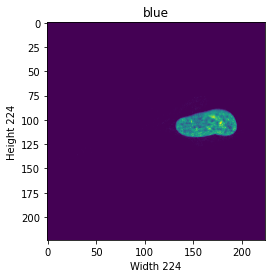

In [11]:
from skimage import exposure
preds_j = []
for n, row in cell_df[:1].iterrows():    
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))
    red = a[:,:,0]    #microtubili
    green = a[:,:,1]  #protein
    blue = a[:,:,2]   #nuclei
    yellow = a[:,:,3] #ER
    image = a[:,:,[0,1,2]]
    
    plt. imshow(blue)
    plt.title('blue')
    plt.ylabel('Height {}'.format(a.shape[0]))
    plt.xlabel('Width {}'.format(a.shape[1]))
    plt.show()
    
    #plt.hist(yellow.ravel(), bins=256)
    #plt.title('Histogram yellow')

    #plt.ylim([0, 300])
    #plt.imshow()
    
    #print(a.shape, a.size, a.max(), a.min())
    a = a.reshape(1, *a.shape)

    #print(a.shape)
    pred = reload_model.predict(a)[0]
    #print(pred)
    preds_j.append(pred)
#preds_j

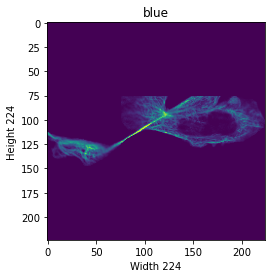

In [9]:
from skimage import exposure
preds_j = []
for n, row in cell_df[:1].iterrows():    
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))
    
    #b = exposure.equalize_adapthist(a, clip_limit=0.03)
    #plt.imshow(b)
    #plt.show()
    
    #print(b.shape, b.size, b.max(), b.min())
    
    red = a[:,:,0]     #microtubili
    green = a[:,:,1]   #protein
    blue = a[:,:,2]    #nuclei
    yellow = a[:,:,3]  #ER
    image = a[:,:,[0,1,2]]
    
    plt. imshow(red)
    plt.title('blue')
    plt.ylabel('Height {}'.format(a.shape[0]))
    plt.xlabel('Width {}'.format(a.shape[1]))
    plt.show()

    
    #plt.hist(green.ravel(), bins=256)
    #plt.title('blue')
    #plt.imshow()
    
    
    a = a.reshape(1, *a.shape)

    #print(a.shape)
    pred = reload_model.predict(a)[0]
    #print(pred)
    preds_j.append(pred)
#preds_j

In [28]:
np.argmax(preds_j, axis = 1)

array([12])

In [12]:
pred_per_cell

[array([0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.4, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.0000000e+00, 2.0000000e-01, 2.2649986e-25, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        6.0000002e-01, 0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([0.2       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.19988886, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ], dtype=float32),
 array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [5]:
import torch 
# convert predictions to torch tensor 
predi = torch.FloatTensor(pred_per_cell)
predi

tensor([[0.0000e+00, 4.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1023e-02, 4.0000e-01, 0.0000e+00,
         0.0000e+00],
        [2.0000e-01, 4.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3091e-10, 3.6556e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00

In [10]:
# set a threshold for what minimal probability the image can be taken into account. Then, return in the cell_df the probability 
# and the cls that belongs to the probability 
threshold = 0.0

for i in range(predi.shape[0]): 
    p = torch.nonzero(predi[i] > threshold).squeeze().numpy().tolist()
    #print(p)
    if type(p) != list: 
        p = [p]
        
    if len(p) == 0: 
        cls = [(predi[i].argmax().item(), predi[i].max().item())]
        #print(cls)
    else: 
        cls = [(x, predi[i][x].item()) for x in p]
        print(cls)
    cell_df['cls'].loc[i] = cls

[(1, 0.4000000059604645), (10, 0.20000000298023224), (15, 0.011023402214050293), (16, 0.4000000059604645)]
[(0, 0.20000000298023224), (1, 0.4000000059604645), (13, 0.4000000059604645)]
[(16, 7.309149396839132e-10), (17, 0.36555933952331543)]
[(15, 0.4000000059604645), (16, 0.1999986171722412)]


In [14]:
cell_df

,image_id,cell_id,enc,cls
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,1,eNq1Vtty4jAM/SUUe+lLp53Z7swOtVGAUBwn5EIgN275/7...,"[(1, 0.6000000238418579), (9, 0.20000000298023..."
1,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2,eNqdUm1PwkAM/kvt3RgYDEaDkZd7QUKiCyIDCRgx8P+/eW...,"[(1, 0.20000000298023224), (2, 2.2649986317073..."
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,3,eNoLCIgJMjbOzTc09AdB48gAP7OgfENbMM/IDyzma+4JoS...,"[(0, 0.20000000298023224), (10, 0.199888855218..."
3,0040581b-f1f2-4fbe-b043-b6bfea5404bb,4,eNqNUsuOwjAM/CXHrliQKg5oWV5NfIDLapG2qAgkLvz/jd...,"[(10, 0.4000000059604645)]"
4,0040581b-f1f2-4fbe-b043-b6bfea5404bb,5,eNp9UV2PmzAQ/Eus7SRVE6k9tbkmtVm+aiA0EAjxBUiA//...,"[(10, 4.1126800447028594e-32)]"
...,...,...,...,...
9848,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,22,eNqNlNkSojoQhl8pDYpTczM1V0ccaEXZZAkQQEBc3v/u5B...,
9849,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,23,eNqVVG1zmzAM/kuSwell+bDrtnQLieUmBMhob9kaSCAl5P...,
9850,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,24,eNp1UNEKwjAM/KWkHfgBPgk20cqYTFBnt5dtZf//5tKurq...,
9851,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,25,eNqlUk1PwzAM/Ut23F5AGgxpXNo4W+myiQ8JGKrqrmv+/4...,


In [10]:
# function to combine the enclosed mask and the prediction (so prob + class)
def combine(r):
    cls = r[0]
    #print(cls)
    enc = r[1]
    classes = [str(c[0]) + ' ' + str(c[1]) + ' ' + enc for c in cls]
    return ' '.join(classes)

In [11]:
# test if it works 
combine(cell_df[['cls', 'enc']].loc[24])

''

In [15]:
# create column pred where the encoded mask and cls is combined for 1 cell 
cell_df['pred'] = cell_df[['cls', 'enc']].apply(combine, axis=1)

In [16]:
cell_df

,image_id,cell_id,enc,cls,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,1,eNq1Vtty4jAM/SUUe+lLp53Z7swOtVGAUBwn5EIgN275/7...,"[(1, 0.6000000238418579), (9, 0.20000000298023...",1 0.6000000238418579 eNq1Vtty4jAM/SUUe+lLp53Z7...
1,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2,eNqdUm1PwkAM/kvt3RgYDEaDkZd7QUKiCyIDCRgx8P+/eW...,"[(1, 0.20000000298023224), (2, 2.2649986317073...",1 0.20000000298023224 eNqdUm1PwkAM/kvt3RgYDEaD...
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,3,eNoLCIgJMjbOzTc09AdB48gAP7OgfENbMM/IDyzma+4JoS...,"[(0, 0.20000000298023224), (10, 0.199888855218...",0 0.20000000298023224 eNoLCIgJMjbOzTc09AdB48gA...
3,0040581b-f1f2-4fbe-b043-b6bfea5404bb,4,eNqNUsuOwjAM/CXHrliQKg5oWV5NfIDLapG2qAgkLvz/jd...,"[(10, 0.4000000059604645)]",10 0.4000000059604645 eNqNUsuOwjAM/CXHrliQKg5o...
4,0040581b-f1f2-4fbe-b043-b6bfea5404bb,5,eNp9UV2PmzAQ/Eus7SRVE6k9tbkmtVm+aiA0EAjxBUiA//...,"[(10, 4.1126800447028594e-32)]",10 4.1126800447028594e-32 eNp9UV2PmzAQ/Eus7SRV...
...,...,...,...,...,...
9848,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,22,eNqNlNkSojoQhl8pDYpTczM1V0ccaEXZZAkQQEBc3v/u5B...,,
9849,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,23,eNqVVG1zmzAM/kuSwell+bDrtnQLieUmBMhob9kaSCAl5P...,,
9850,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,24,eNp1UNEKwjAM/KWkHfgBPgk20cqYTFBnt5dtZf//5tKurq...,,
9851,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,25,eNqlUk1PwzAM/Ut23F5AGgxpXNo4W+myiQ8JGKrqrmv+/4...,,


In [17]:
# combine the pred column for all the images with the same image_id 
subm = cell_df.groupby(['image_id'])['pred'].apply(lambda x: ' '.join(x)).reset_index()

In [18]:
subm

,image_id,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,1 0.6000000238418579 eNq1Vtty4jAM/SUUe+lLp53Z7...
1,004a270d-34a2-4d60-bbe4-365fca868193,
2,00537262-883c-4b37-a3a1-a4931b6faea5,
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,
4,0173029a-161d-40ef-af28-2342915b22fb,
...,...,...
486,fe368fb1-9dc6-472b-9a33-aba3d1477626,
487,feb955db-6c07-4717-a98b-92236c8e01d8,
488,fefb9bb7-934a-40d1-8d2f-210265857388,
489,ff069fa2-d948-408e-91b3-034cfea428d1,


In [19]:
# merge the 2 dataframes 
sub = pd.merge(
    sample_submission,
    subm,
    how="left",
    left_on='ID',
    right_on='image_id',
)

In [20]:
sub

,ID,ImageWidth,ImageHeight,PredictionString,image_id,pred
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0040581b-f1f2-4fbe-b043-b6bfea5404bb,1 0.6000000238418579 eNq1Vtty4jAM/SUUe+lLp53Z7...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,004a270d-34a2-4d60-bbe4-365fca868193,
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,00537262-883c-4b37-a3a1-a4931b6faea5,
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,00c9a1c9-2f06-476f-8b0d-6d01032874a2,
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==,0173029a-161d-40ef-af28-2342915b22fb,
...,...,...,...,...,...,...
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,0 1 eNoLCAjJNgIABNkBkg==,NaN,NaN
555,feb955db-6c07-4717-a98b-92236c8e01d8,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,feb955db-6c07-4717-a98b-92236c8e01d8,
556,fefb9bb7-934a-40d1-8d2f-210265857388,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,fefb9bb7-934a-40d1-8d2f-210265857388,
557,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==,ff069fa2-d948-408e-91b3-034cfea428d1,


In [6]:
def tta_aug(img):
    
    Geo_transform = A.Compose([

            A.Rotate(limit = 90, p=0.5),
            #A.RandomRotate90(always_apply=False, p=0.5),

            A.Transpose(p=0.5),

            A.HorizontalFlip(p=0.5),

            A.VerticalFlip(p=0.5),

            A.ShiftScaleRotate(p=0.5)
        
            #A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5)
    ])
    
    b = Geo_transform(image = img)
    transformed = b['image']             #array
    
    #e=Image.fromarray(transformed)
    
    aug_img = transformed.reshape(1, *transformed.shape)
    
    return aug_img

In [9]:
tta_n = 4
preds_j = []
for n, row in cell_df[:1].iterrows():
    a = plt.imread("/media/beta/mitko-beps/data/segmented_test/{}_{}.png".format(row['image_id'], row['cell_id']))   
    
    aug_pred =[]
    for i in range(tta_n):
        d = tta_aug(a)
        print(type(d))
        pred_img = reload_model.predict(d)[0]
        aug_pred.append(pred_img)
    
    a_og = a.reshape(1, *a.shape)
    pred_og = reload_model.predict(a_og)[0]
    aug_pred.append(pred_og)
    
    pred = np.mean(aug_pred, axis=0)
    preds_j.append(pred)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
